# 1. Optical Flow

![optical flow](https://developer-blogs.nvidia.com/wp-content/uploads/2019/02/Football-768x216.png)

For the first "Climate Hack" sample solution let's have a look at the **optical flow** method that seems to do do surprisingly well in forecasting future images (especially, when combined with other methods).

The first part of the following notebook will cover the rough basic principles of the optical flow that might be useful for the further development of the system. The second part, will demonstrate how such algorithm could be implemented for our task.

## Theory

Optical flow is the patten of motion of objects between two consecutive frames due to movement of the object or camera. Mathematically it is a vector  field that shows the displacement vectors of pixels (points) between the frames.

As one can imagine, it is a computationally intense algorithm, therefore, it works on several assumptions:

- The background lighting intensity is not changing
- Near pixels have similar motion

We are not going to cover the underlying mathematical principles, as multiple Python libraries already come with functions that calculate optical flow for you.

In the following bit, we will see how such optical system can be implemented for our satellite imagery problem.

## Implementation

#### Importing modules

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
from numpy import float32
from torch.utils.data import DataLoader
from dataset import ClimateHackDataset
import cv2
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 12)

#### Reading data

As this tutorial is focused on developing optical flow system, we are going to use the same exact dataset loader as in the sample submission folder. In contrast to the initial file, we are going to use locally saved sample dataset (```data.npz```) just to vary things a bit.

In [3]:
BATCH_SIZE = 1
EPOCHS = 35

ch_dataset = ClimateHackDataset("data.npz", crops_per_slice=1)
ch_dataloader = DataLoader(ch_dataset, batch_size=BATCH_SIZE, pin_memory=True)

#Feature images
features = []
#Target images
targets = []

for batch_coordinates, batch_features, batch_targets in ch_dataloader:
    features.append(batch_features)
    targets.append(batch_targets)

### Computing optical flow

For computing optical flow (and then predicting future images), we are going to use ```calcOpticalFlowFarneback``` function that is specifically created for dense optical flow computation. In short, we are passing a batch of *'historical'* images through the algorithm to calculated the weighted mean of the generated flow fields that then improves our future prediction.

For starters, we are going to compute and plot the optical flow for the sample batch of images.

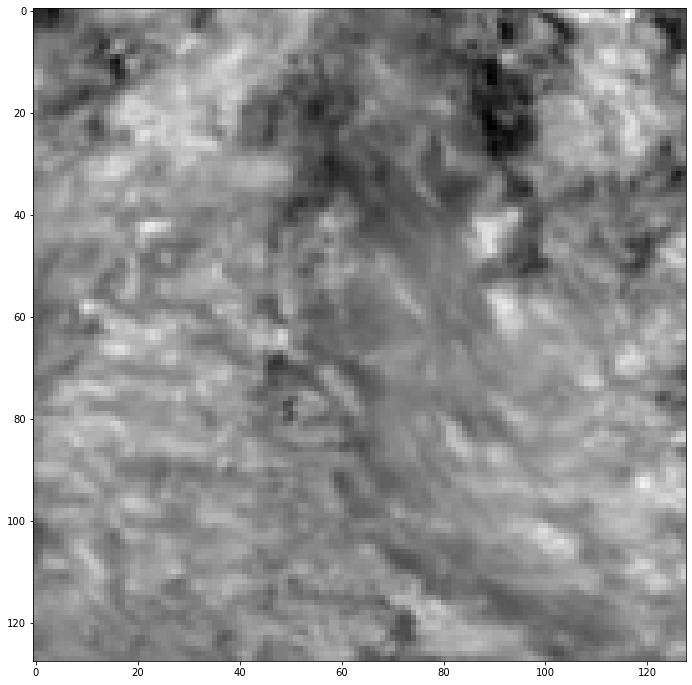

In [4]:
#Sample batch
img = batch_features[0].numpy() / 1023

#Defining the number of previous images
NUM_PREVIOUS_IMAGES = 12

#Number of images for prediction
NUM_PREDICTION_IMAGES = 24

#Plotting sample image in grayscale
plt.imshow(img[0], cmap = 'gray')

In [5]:
# This is our 'main' function for computing optical flow
def compute_flows(**kwargs):
    flows = []
    for i in range(NUM_PREVIOUS_IMAGES):
        flow = cv2.calcOpticalFlowFarneback(prev=img[i-1], next=img[i], flow=None, **kwargs)
        flows.append(flow)
    return np.stack(flows).astype(np.float32)

# Function for averaging generated flows
def weighted_average(flows):
    return np.average(flows, axis=0, weights=range(1, NUM_PREVIOUS_IMAGES+1)).astype(np.float32)

After defining our optical flow functions, let's calculate optical flow for our batch of sample images. For the starting configuration, we are going to use default parameter values (feel free to change them).

In [6]:
flows = compute_flows(
    pyr_scale=0.5, levels=3, winsize=15, 
    iterations=10, poly_n=5, poly_sigma=1.2, 
    flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

flows = weighted_average(flows)

Now, let's visualize the optical flow we have just computed. For more in-depth visualization, we are going to use HSV color representation.

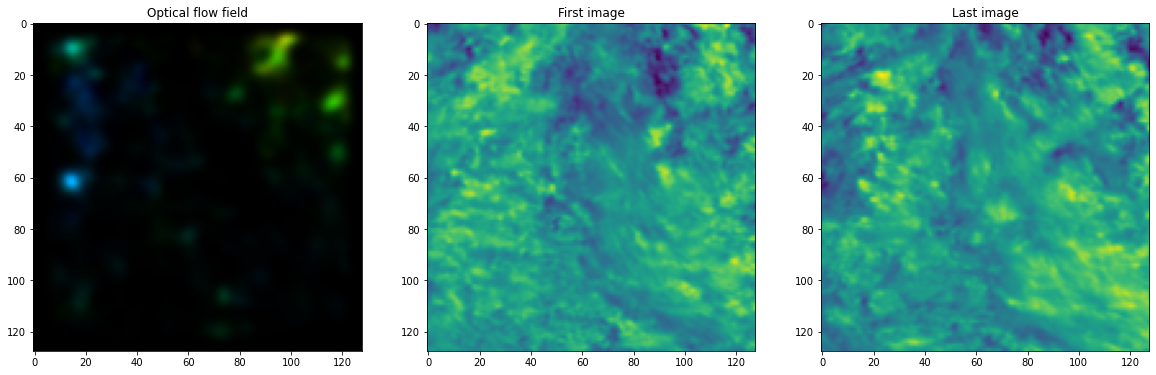

In [7]:
magnitude, angle = cv2.cartToPolar(flows[..., 0], flows[..., 1])

#Creating placefolder for our image
hsv_shape = img[0].shape + (3,)
hsv = np.zeros(shape=hsv_shape, dtype=np.uint8) 

#Controlling hue according to angle
hsv[..., 0] = angle * 180 / np.pi / 2

# Setting saturation to maximum 
hsv[..., 1] = 255

# Setting magnitude accoring to the optical flow value (normalized)
hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
# Converts HSV to RGB (BGR) color representation 
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
fig, axes = plt.subplots(figsize=(20, 10), ncols=3)
axes[0].set_title('Optical flow field')
axes[0].imshow(rgb)
axes[1].set_title('First image')
axes[1].imshow(img[0])
axes[2].set_title('Last image')
axes[2].imshow(img[NUM_PREVIOUS_IMAGES-1])

### Predicting images

The average optical flow we have just calculated then can be used to predict further images simply warping around images in time. In simple terms, optical flow demonstrates the movement of pixels between consecutive frames, therefore, we can follow the same movement and directions to generate new images.

In [8]:
#Function for warming image in the flow direction
def remap_image(image: np.ndarray, flow: np.ndarray) -> np.ndarray:

    height, width = flow.shape[:2]
    remap = -flow.copy()
    remap[..., 0] += np.arange(width)
    remap[..., 1] += np.arange(height)[:, np.newaxis]
    remapped_image = cv2.remap(src=image, map1=remap, map2=None, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    
    # Remember that the output has to be 64x64
    return cv2.resize(remapped_image, (64, 64))

In [9]:
# Generating new images
start_image = img[-1]

# Array for storing output
output = []

for i in range(NUM_PREDICTION_IMAGES):
    remapped_image = remap_image(start_image, flows * i)
    
    output.append(remapped_image)

Now let's plot some predictions and real images.

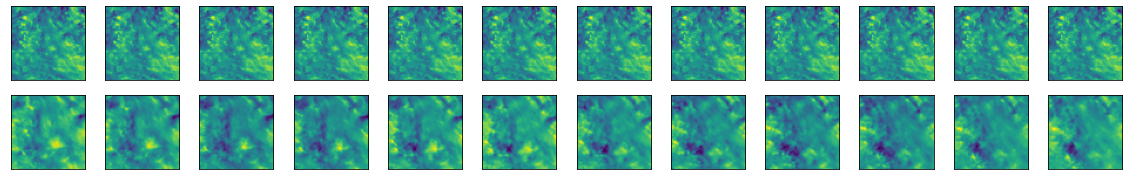

In [10]:
# Extracting target images for the first batch
y = batch_targets[0].numpy()

fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(20,3))

# plot twelve 64x64 predicted images
for i, img in enumerate(output[:12]):
    ax1[i].imshow(img, cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

# plot twelve 64x64 true output images
for i, img in enumerate(y[:12]):
    ax2[i].imshow(img, cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

### Deploying system

The purpose of this notebook was to demonstrate that simple optical flow model can provide quite accurate predictions. To actually deploy such system, you would need to transfer all functions in a ```model.py``` file that would then be called by evaluation script. As a result, you would need to changed the initial ```model.py``` and ```evaluate.py``` scripts.

***Depending on the time you are reading this source, such scripts may already be available to use***